In [4]:
!pip install pytorch-tabnet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 3.0 MB/s eta 0:00:00


In [6]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.metrics import precision_recall_curve, roc_auc_score, f1_score, matthews_corrcoef, classification_report
from pytorch_tabnet.tab_model import TabNetClassifier
from imblearn.over_sampling import SMOTE



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset Shape: (284807, 31)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17  

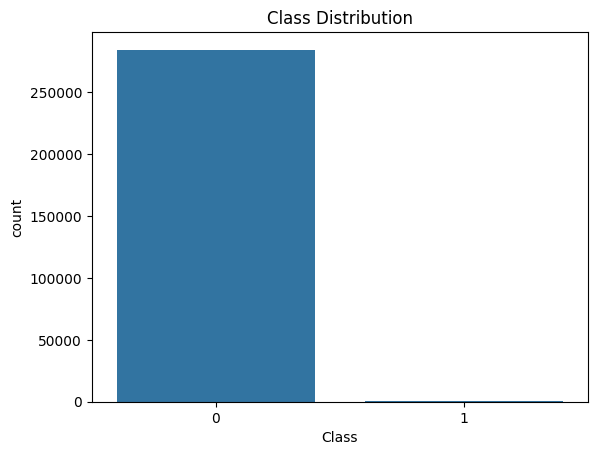

In [7]:
# Load dataset from Google Drive
from google.colab import drive
drive.mount('/content/drive')
file_path = "/content/drive/MyDrive/Credit Card Fraud Detection/creditcard.csv"  # Replace with your file path
data = pd.read_csv(file_path)

# Dataset Information
print("Dataset Shape:", data.shape)
print(data.info())
print("Class Distribution:\n", data['Class'].value_counts())

# Visualize class distribution
sns.countplot(x='Class', data=data)
plt.title("Class Distribution")
plt.show()


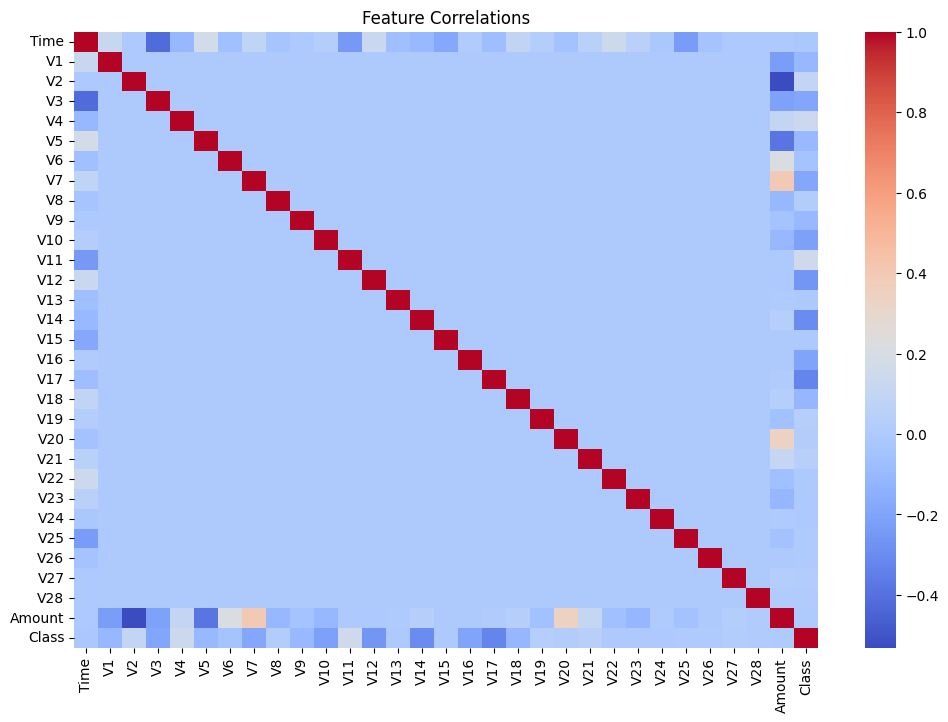

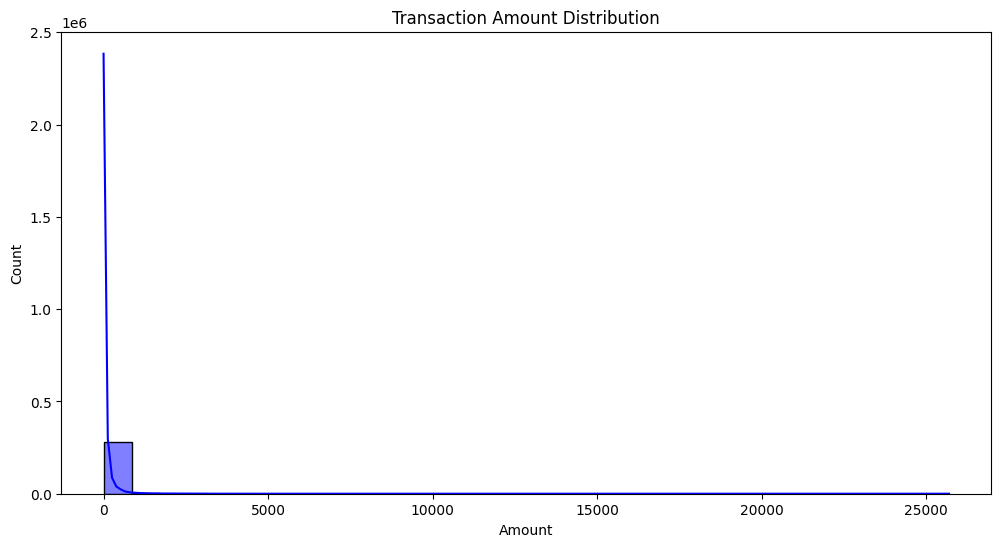

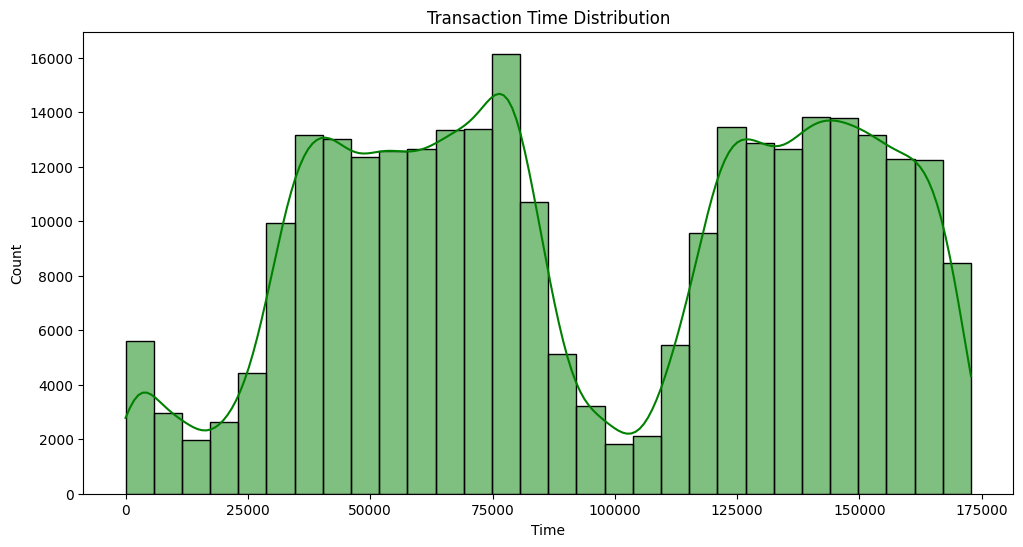

In [8]:
# Correlation heatmap
correlation_matrix = data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, cmap="coolwarm", annot=False)
plt.title("Feature Correlations")
plt.show()

# Analyze 'Amount' and 'Time' distributions
plt.figure(figsize=(12, 6))
sns.histplot(data['Amount'], kde=True, bins=30, color="blue")
plt.title("Transaction Amount Distribution")
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(data['Time'], kde=True, bins=30, color="green")
plt.title("Transaction Time Distribution")
plt.show()


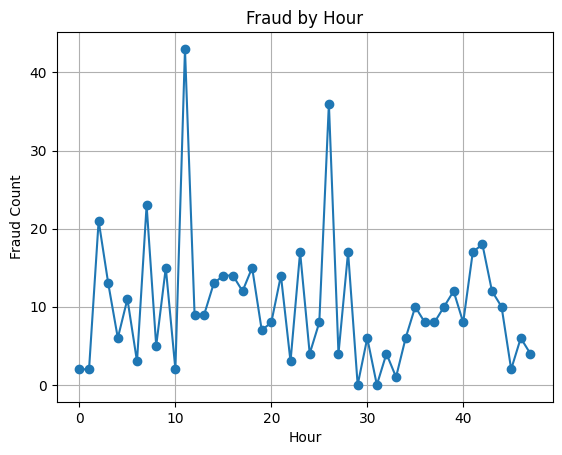

In [9]:
# Create interaction features
data['Amount_log'] = np.log1p(data['Amount'])  # Log-transform skewed 'Amount'
data['Hour'] = data['Time'] // 3600  # Extract transaction hour
data['V1_V2_interaction'] = data['V1'] * data['V2']  # Example of interaction feature

# Group by time windows to identify trends
hourly_fraud = data.groupby('Hour')['Class'].sum()
plt.plot(hourly_fraud.index, hourly_fraud.values, marker='o')
plt.title("Fraud by Hour")
plt.xlabel("Hour")
plt.ylabel("Fraud Count")
plt.grid(True)
plt.show()


In [10]:
# Outlier detection with Isolation Forest
iso = IsolationForest(contamination=0.01, random_state=42)
outliers = iso.fit_predict(data.drop(['Class'], axis=1))
data = data[outliers == 1]  # Remove detected outliers

# Standardize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data.drop(['Class'], axis=1))
data_scaled = pd.DataFrame(scaled_features, columns=data.drop(['Class'], axis=1).columns)
data_scaled['Class'] = data['Class'].values


In [11]:
# Apply SMOTE for class balancing
X = data_scaled.drop('Class', axis=1)
y = data_scaled['Class']
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)


In [12]:
# Initialize Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Placeholder for results
results = []

for train_index, test_index in skf.split(X_resampled, y_resampled):
    X_train, X_test = X_resampled.iloc[train_index], X_resampled.iloc[test_index]
    y_train, y_test = y_resampled.iloc[train_index], y_resampled.iloc[test_index]


In [14]:
# Initialize TabNet model
clf = TabNetClassifier(seed=42, verbose=1)

# Define a maximum threshold for epochs
max_epochs = 100
patience_threshold = 10  # Number of epochs to wait for improvement before stopping

# Fit TabNet model with early stopping
clf.fit(
    X_train.values, y_train.values,
    eval_set=[(X_test.values, y_test.values)],
    eval_name=['valid'],
    eval_metric=['auc'],
    max_epochs=max_epochs,
    patience=patience_threshold,  # Stops if no improvement after `patience_threshold` epochs
    batch_size=1024,
    virtual_batch_size=128
)

# Make predictions
y_pred_proba = clf.predict_proba(X_test.values)[:, 1]
y_pred = (y_pred_proba > 0.5).astype(int)

# Evaluate performance
roc_auc = roc_auc_score(y_test, y_pred_proba)
f1 = f1_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)

print("ROC-AUC:", roc_auc)
print("F1-Score:", f1)
print("MCC:", mcc)


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.13509 | valid_auc: 0.99796 |  0:00:35s
epoch 1  | loss: 0.05368 | valid_auc: 0.99925 |  0:01:06s
epoch 2  | loss: 0.03391 | valid_auc: 0.99954 |  0:01:37s
epoch 3  | loss: 0.02654 | valid_auc: 0.99968 |  0:02:08s
epoch 4  | loss: 0.02031 | valid_auc: 0.99977 |  0:02:39s
epoch 5  | loss: 0.01781 | valid_auc: 0.99982 |  0:03:09s
epoch 6  | loss: 0.01481 | valid_auc: 0.99983 |  0:03:40s
epoch 7  | loss: 0.01563 | valid_auc: 0.99973 |  0:04:12s
epoch 8  | loss: 0.01545 | valid_auc: 0.99987 |  0:04:43s
epoch 9  | loss: 0.01156 | valid_auc: 0.99985 |  0:05:15s
epoch 10 | loss: 0.01248 | valid_auc: 0.99977 |  0:05:46s
epoch 11 | loss: 0.01079 | valid_auc: 0.99992 |  0:06:17s
epoch 12 | loss: 0.01344 | valid_auc: 0.99989 |  0:06:48s
epoch 13 | loss: 0.01048 | valid_auc: 0.9999  |  0:07:19s
epoch 14 | loss: 0.00907 | valid_auc: 0.99993 |  0:07:49s
epoch 15 | loss: 0.00951 | valid_auc: 0.99994 |  0:08:19s
epoch 16 | loss: 0.01134 | valid_auc: 0.99963 |  0:08:50s
epoch 17 | los

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


ROC-AUC: 0.9999779670382177
F1-Score: 0.9993879777543219
MCC: 0.9987759550498707
